In [1]:
%matplotlib inline
%run utils.py
import os.path as osp
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotnine as pn
import matplotlib.pyplot as plt

In [96]:
df_pub = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstracts.csv'))
df_pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52174 entries, 0 to 52173
Data columns (total 5 columns):
abstract    46582 non-null object
date        18497 non-null object
id          52174 non-null int64
terms       52174 non-null object
title       52172 non-null object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [3]:
df_ct = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_tcell_types.csv'))
df_ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11524 entries, 0 to 11523
Data columns (total 6 columns):
type        11524 non-null object
count       11524 non-null int64
id          11524 non-null int64
type_key    7045 non-null object
type_lbl    7045 non-null object
type_lvl    7045 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 540.3+ KB


In [4]:
df_pr = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_proteins_resolved.csv'))
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61175 entries, 0 to 61174
Data columns (total 8 columns):
id            61175 non-null int64
start         61175 non-null int64
end           61175 non-null int64
value         61175 non-null object
class         61175 non-null object
value_norm    61175 non-null object
value_lbl     61175 non-null object
value_sym     17228 non-null object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


In [7]:
df_mg = pd.read_csv(osp.join(DATA_DIR, 'pubmed_mygene_protein_annotations.csv'))
df_mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7202 entries, 0 to 7201
Data columns (total 8 columns):
id               7202 non-null object
score            7202 non-null float64
sym              7202 non-null object
name             7202 non-null object
ensemblgene      5788 non-null object
species          7202 non-null object
pr_value_norm    7202 non-null object
is_tf            7202 non-null bool
dtypes: bool(1), float64(1), object(6)
memory usage: 401.0+ KB


## Merge

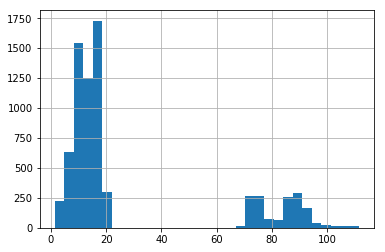

In [188]:
df_mg['score'].hist(bins=32)

In [189]:
df_mg_tf = (
    df_mg[(df_mg['is_tf'].values == True) & (df_mg['score'] >= 30)]
    # Get top hit for each term and species
    .groupby(['pr_value_norm', 'species'], group_keys=False)
    .apply(lambda g: g.sort_values('score').tail(1))
    .reset_index()
    # Group by term and summarize everything else (mostly for debugging)
    .groupby('pr_value_norm').apply(lambda g: pd.Series({
        'species': g['species'].dropna().str.cat(sep=','),
        'syms': g['sym'].str.cat(sep=','),
        'eids': g['ensemblgene'].str.cat(sep=','),
        'scores': g['score'].astype(int).astype(str).str.cat(sep=',')
    }))
    .reset_index()
    .rename(columns={'pr_value_norm': 'value_norm'})
)
assert df_mg_tf['value_norm'].is_unique
df_mg_tf.head()

,value_norm,species,syms,eids,scores
0,AHR,human,AHR,ENSG00000106546,88
1,AIRE,human,AIRE,ENSG00000160224,85
2,AR,human,AR,ENSG00000169083,85
3,ASCL2,human,ASCL2,ENSG00000183734,92
4,ASH1L,human,ASH1L,ENSG00000116539,85


In [190]:
# Get protein term mention counts per doc
df = df_pr.groupby(['id', 'value_norm']).size().rename('pr_count').reset_index()

# Add TF metadata as inner join (implicit filter to TF only proteins)
df = pd.merge(df, df_mg_tf, on='value_norm', how='inner')
assert df.groupby(['id', 'value_norm']).size().max() == 1

# Add cell types
df = pd.merge(
    df, 
    df_ct.add_prefix('ct_').rename(columns={'ct_id': 'id'})
        .groupby(['id', 'ct_type_key'])['ct_count'].sum().reset_index(),
    on='id',
    how='left'
)
assert df['ct_count'].notnull().all()

df.head()

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
0,6242007,CIC,1,human,CIC,ENSG00000079432,88,TH,1
1,8724834,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
2,15668741,RAG1,1,human,RAG1,ENSG00000166349,85,TREG,1
3,19502389,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
4,20208000,RAG1,3,human,RAG1,ENSG00000166349,85,TREG,1


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2737
Data columns (total 9 columns):
id             2738 non-null int64
value_norm     2738 non-null object
pr_count       2738 non-null int64
species        2738 non-null object
syms           2738 non-null object
eids           2738 non-null object
scores         2738 non-null object
ct_type_key    2738 non-null object
ct_count       2738 non-null int64
dtypes: int64(3), object(6)
memory usage: 213.9+ KB


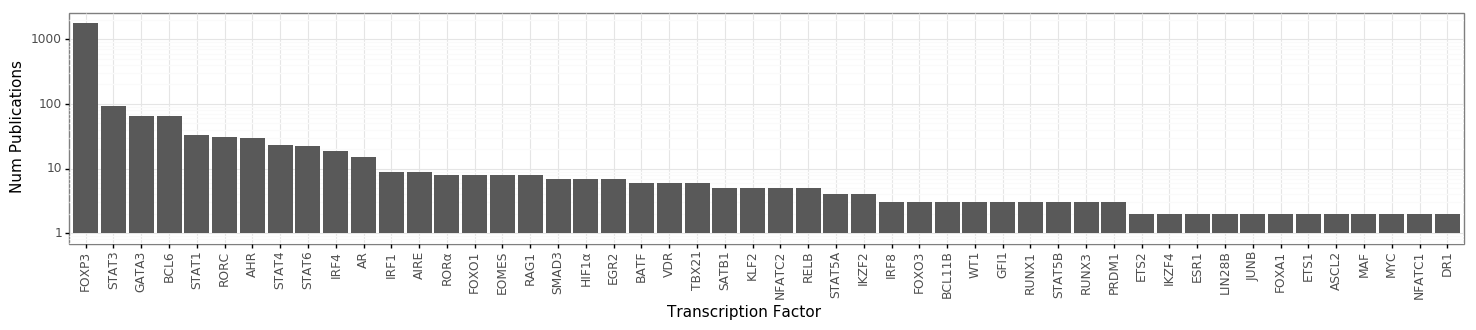

<ggplot: (352928253)>

In [192]:
# Number of documents per TF
(
    pn.ggplot(
        df.groupby('value_norm')['id'].nunique().rename('count')
        .sort_values(ascending=False).head(50).reset_index()
        .assign(typ=lambda df: pd.Categorical(
            df['value_norm'], ordered=True,
            categories=df['value_norm'].unique()
        )),
        pn.aes(x='typ', y='count', label='count')
    ) + 
    pn.geom_bar(stat='identity') +
    pn.labs(x='Transcription Factor', y='Num Publications') +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(18, 3), axis_text_x = pn.element_text(angle = 90, hjust = .5))
)


In [193]:
df.head()

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
0,6242007,CIC,1,human,CIC,ENSG00000079432,88,TH,1
1,8724834,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
2,15668741,RAG1,1,human,RAG1,ENSG00000166349,85,TREG,1
3,19502389,RAG1,1,human,RAG1,ENSG00000166349,85,TH1,1
4,20208000,RAG1,3,human,RAG1,ENSG00000166349,85,TREG,1


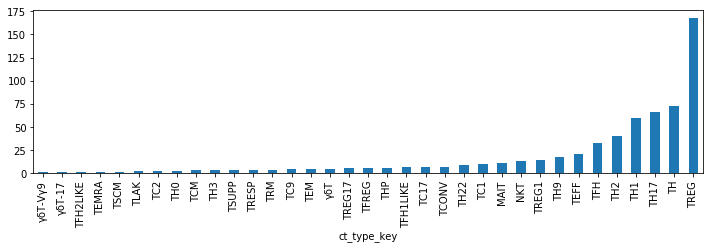

In [194]:
df_score.groupby('ct_type_key')['value_norm'].nunique().sort_values().plot(kind='bar', figsize=(12, 3))

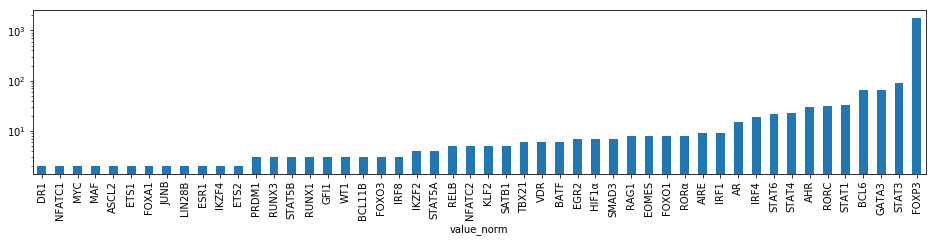

In [195]:
ax = df.groupby('value_norm')['id'].nunique().sort_values().tail(50).plot(kind='bar', figsize=(16, 3))
ax.set_yscale('log')

In [196]:
df_score = pd.concat([
    df.groupby(['ct_type_key', 'value_norm'])
        .agg({'pr_count': 'sum', 'id': 'nunique'})
        .rename(columns={'id': 'pr_ct_nuniq_pub'})
        .reset_index('ct_type_key'),
    df.groupby(['value_norm'])
        .agg({'id': 'nunique', 'ct_type_key': 'nunique'})
        .rename(columns={'id': 'pr_nuniq_pub', 'ct_type_key': 'pr_nuniq_ct'})
], join='inner', axis=1).reset_index()

df_score['score'] = df_score['pr_count'].apply(np.sqrt) / df_score['pr_nuniq_ct']

df_score = (
    df_score.groupby(['ct_type_key'], group_keys=False)
    .apply(lambda g: 
           g.sort_values('score', ascending=False)
           .assign(rank=np.arange(len(g))+1, score_norm=lambda dg: dg['score']/dg['score'].sum())
    )
)

df_score.head()

,value_norm,ct_type_key,pr_count,pr_ct_nuniq_pub,pr_nuniq_pub,pr_nuniq_ct,score,rank,score_norm
3,ZBTB16,MAIT,2,1,1,2,0.707107,1,0.688304
0,EOMES,MAIT,3,2,8,8,0.216506,2,0.210749
2,STAT3,MAIT,1,1,92,15,0.066667,3,0.064894
1,FOXP3,MAIT,1,1,1778,27,0.037037,4,0.036052
7,LIN28B,NKT,2,1,2,2,0.707107,1,0.280415


In [197]:
# (
#     df_score[df_score['rank'] <= 15]
#         .assign(pr_nuniq_pub=lambda df: pd.cut(df['pr_nuniq_pub'], bins=[0, 1, 10, 50, np.inf]))
#         .assign(pr_ct_nuniq_pub=lambda df: pd.cut(df['pr_ct_nuniq_pub'], bins=[0, 1, 3, 10, np.inf]))
#         .assign(cell_type=lambda df: pd.Categorical(
#             df['ct_type_key'], ordered=True,
#             categories=df['ct_type_key'].value_counts().sort_values().index
#         ))
#         .pivot(index='cell_type', columns='rank', values='value_norm')
# )

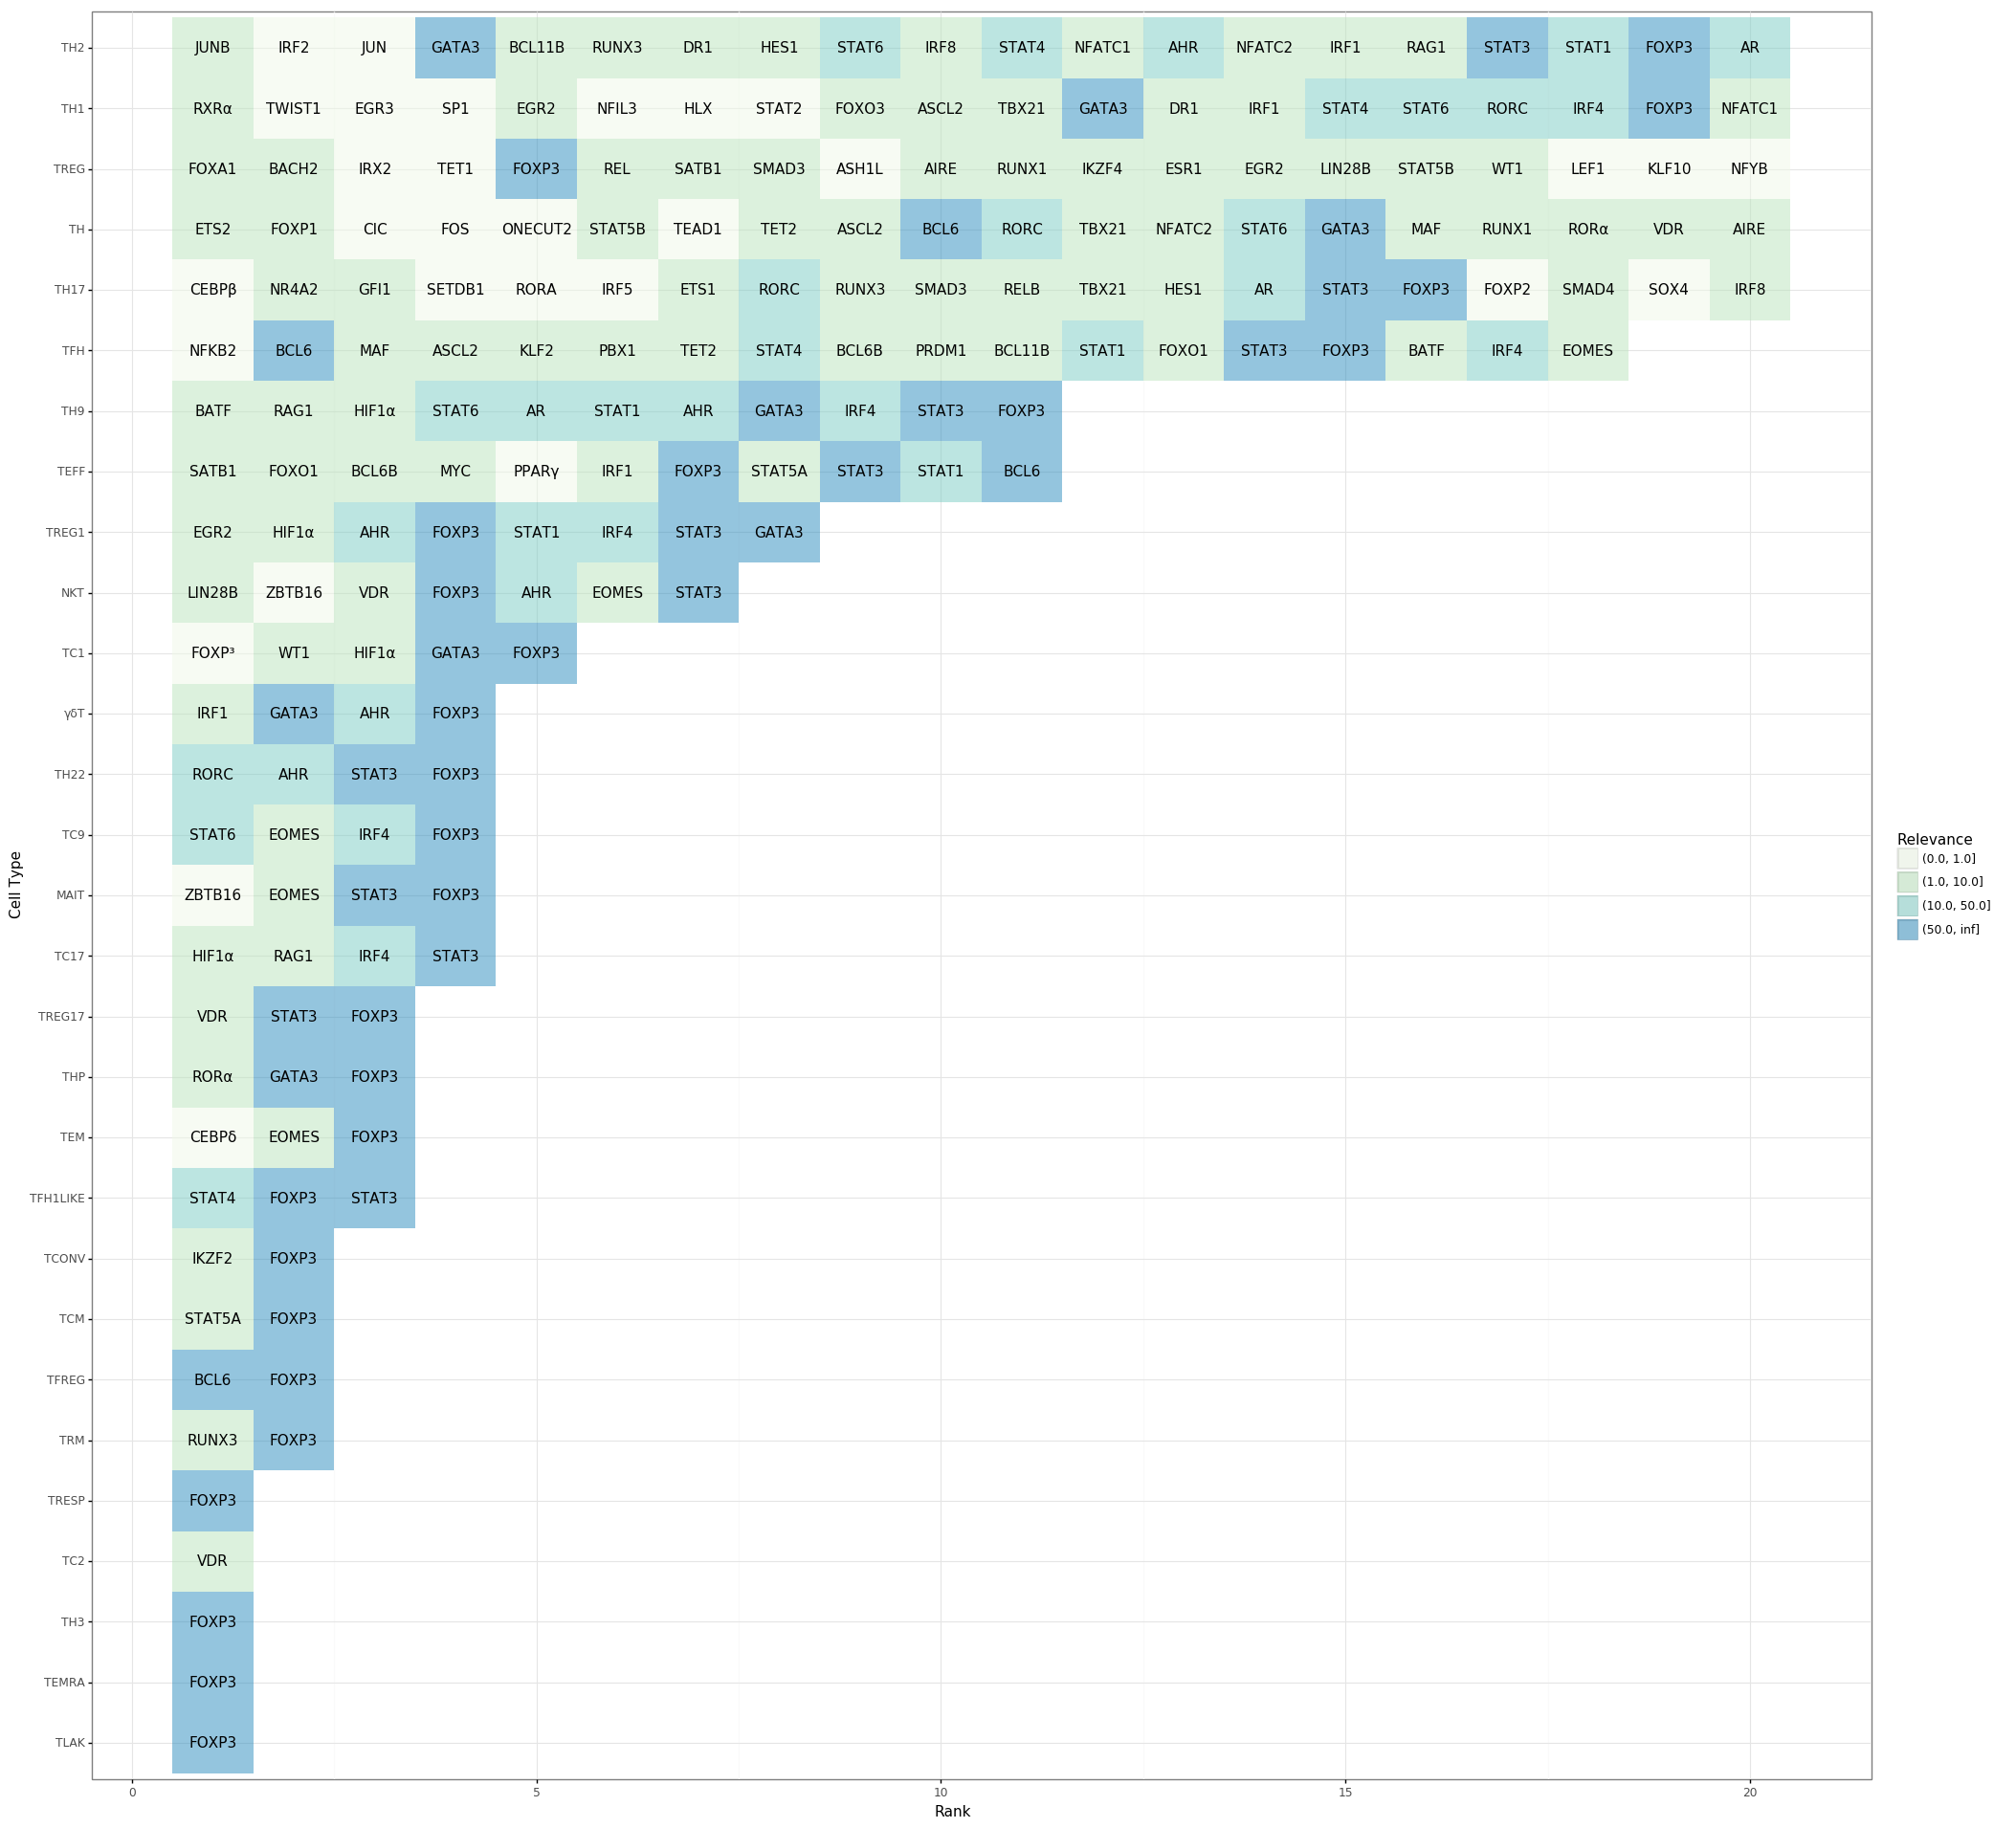

<ggplot: (356621274)>

In [223]:
(
    pn.ggplot(
        df_score[df_score['rank'] <= 20]
        .assign(pr_nuniq_pub=lambda df: pd.cut(df['pr_nuniq_pub'], bins=[0, 1, 10, 50, np.inf]))
        .assign(pr_ct_nuniq_pub=lambda df: pd.cut(df['pr_ct_nuniq_pub'], bins=[0, 1, 3, 10, np.inf]))
        .assign(cell_type=lambda df: pd.Categorical(
            df['ct_type_key'], ordered=True,
            categories=df['ct_type_key'].value_counts().sort_values().index
        )),
        pn.aes(y='cell_type', x='rank', label='value_norm', fill='pr_nuniq_pub')
    ) + 
    pn.geom_tile(alpha=.5) + 
    #pn.scale_fill_cmap_d('Blues') +
    pn.scale_fill_brewer(palette='GnBu') +
    #pn.scale_size_discrete(range=(10, 14)) +
    pn.geom_text(color='black', alpha=1) + 
    pn.labs(fill='Relevance', x='Rank', y='Cell Type') +
    pn.theme_bw() +
    pn.theme(figure_size=(24, 24)) 
)

In [221]:
df['value_norm'].nunique()

99

In [220]:
df['value_norm'].sort_values().unique()

array(['AHR', 'AIRE', 'AR', 'ASCL2', 'ASH1L', 'ATF3', 'BACH2', 'BATF',
       'BCL11B', 'BCL6', 'BCL6B', 'CEBPβ', 'CEBPδ', 'CIC', 'DBP', 'DNMT1',
       'DR1', 'EGR2', 'EGR3', 'EOMES', 'ESR1', 'ETS1', 'ETS2', 'FOS',
       'FOXA1', 'FOXO1', 'FOXO3', 'FOXP1', 'FOXP2', 'FOXP3', 'FOXP³',
       'GATA1', 'GATA3', 'GFI1', 'GLI1', 'HES1', 'HEY1', 'HIF1α', 'HLX',
       'IKZF2', 'IKZF4', 'IRF1', 'IRF2', 'IRF4', 'IRF5', 'IRF8', 'IRX2',
       'JUN', 'JUNB', 'KLF10', 'KLF2', 'LEF1', 'LIN28B', 'MAF', 'MYC',
       'NFATC1', 'NFATC2', 'NFIL3', 'NFKB2', 'NFYB', 'NR4A1', 'NR4A2',
       'NR4A3', 'ONECUT2', 'PBX1', 'PPARγ', 'PRDM1', 'RAG1', 'REL',
       'RELB', 'RORA', 'RORC', 'RORα', 'RUNX1', 'RUNX3', 'RXRα', 'SATB1',
       'SETDB1', 'SMAD1', 'SMAD3', 'SMAD4', 'SOX4', 'SP1', 'STAT1',
       'STAT2', 'STAT3', 'STAT4', 'STAT5A', 'STAT5B', 'STAT6', 'TBX21',
       'TEAD1', 'TET1', 'TET2', 'TWIST1', 'VDR', 'WT1', 'XBP1', 'ZBTB16'],
      dtype=object)

In [224]:
pr = 'HIF1α'
df_score[df_score['value_norm'] == pr]

,value_norm,ct_type_key,pr_count,pr_ct_nuniq_pub,pr_nuniq_pub,pr_nuniq_ct,score,rank,score_norm
14,HIF1α,TC1,1,1,7,5,0.200000,3,0.077849
16,HIF1α,TC17,1,1,7,5,0.200000,1,0.328900
199,HIF1α,TH9,2,1,7,5,0.282843,3,0.144771
237,HIF1α,TREG,10,4,7,5,0.632456,42,0.009082
286,HIF1α,TREG1,5,1,7,5,0.447214,2,0.200279


In [225]:
df[df['value_norm'] == pr]

,id,value_norm,pr_count,species,syms,eids,scores,ct_type_key,ct_count
2484,18792019,HIF1α,7,human,HIF1A,ENSG00000100644,85,TREG,1
2485,26005855,HIF1α,5,human,HIF1A,ENSG00000100644,85,TREG1,1
2486,27317260,HIF1α,2,human,HIF1A,ENSG00000100644,85,TH9,1
2487,27716621,HIF1α,1,human,HIF1A,ENSG00000100644,85,TREG,1
2488,27918097,HIF1α,1,human,HIF1A,ENSG00000100644,85,TREG,1
2489,28382159,HIF1α,1,human,HIF1A,ENSG00000100644,85,TREG,1
2490,28542595,HIF1α,1,human,HIF1A,ENSG00000100644,85,TC1,1
2491,28542595,HIF1α,1,human,HIF1A,ENSG00000100644,85,TC17,1


In [205]:
#df_pub[df_pub['id'].isin(df[df['value_norm'] == pr]['id'])][['id', 'abstract']]

In [226]:
#df_pub[df_pub['id'].isin(df[df['value_norm'] == pr]['id'])][['id', 'abstract']].iloc[1]['abstract']
df_pub[df_pub['id'] == 26005855].iloc[0]['abstract']

'Our understanding of the pathways that regulate lymphocyte metabolism, as well as the effects of metabolism and its products on the immune response, is still limited. We report that a metabolic program controlled by the transcription factors hypoxia inducible factor-1α (HIF1-α) and aryl hydrocarbon receptor (AHR) supports the differentiation of type 1 regulatory T cell (Tr1) cells. HIF1-α controls the early metabolic reprograming of Tr1 cells. At later time points, AHR promotes HIF1-α degradation and takes control of Tr1 cell metabolism. Extracellular ATP (eATP) and hypoxia, linked to inflammation, trigger AHR inactivation by HIF1-α and inhibit Tr1 cell differentiation. Conversely, CD39 promotes Tr1 cell differentiation by depleting eATP. CD39 also contributes to Tr1 suppressive activity by generating adenosine in cooperation with CD73 expressed by responder T cells and antigen-presenting cells. These results suggest that HIF1-α and AHR integrate immunological, metabolic and environme

ZBTB16 | 23223428 | MAIT/NKT | Knockdown of the transcription factor PLZF/ZBTB-16, which is involved in the effector program of iNKT cells, diminishes their proapoptotic phenotype. Conversely, overexpression of PLZF/ZBTB-16 in conventional T cells leads to a proapoptotic phenotype.
STAT6 | 23254356 | TC9 | Similarly to the CD4(+) counterpart, Tc9 cells required for their differentiation STAT6 and IRF4.
HIF1α | 26005855 | TREG1 | We report that a metabolic program controlled by the transcription factors hypoxia inducible factor-1α (HIF1-α) and aryl hydrocarbon receptor (AHR) supports the differentiation of type 1 regulatory T cell (Tr1) cells.